## Fitting Prompt and Non-Prompt photon $p_T$ distributions

### The Fits are used to flatten the $p_T$ distributions such that they are not trained in the neural net

**Dataset 'X' Holds Cluster Varlibales. Each cluster has 29 variables from ROOT NTuple.**
- 0-24 = Cell Fractional Energy (5x5 Cells). 0 if null.
- 25 = Inv.Sqrt(Cluster_E)
- 26 = Cluster Eta (Pseudo Rapidity)
- 27 = min_sm_dazimuth (Line 204 Conver_Sample.cc)
- 28 = v0 multiplicity (saved per cluster?)

**Dataset 'y' holds prompt/non-prompt integer. 1 = prompt; 0 = non-prompt**

In [1]:
from scipy.optimize import curve_fit
import scipy
import math
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
f = h5py.File('embed_20g3d_pthat4_15o_246392.hdf5', 'r')
cluster_vars = f['X'] 
prompt_bools = f['y']

#combine into single dataset: Element 29 = prompt bool
cluster_dset = np.hstack([cluster_vars,prompt_bools])

**Create Prompt and Non-Prompt Datasets using "Masking"**

In [3]:
prompt = cluster_dset[cluster_dset[:,29] == 1] #Select Prompt Clusters
non_prompt = cluster_dset[cluster_dset[:,29] == 0] #Selects Non-Prompt Clusters

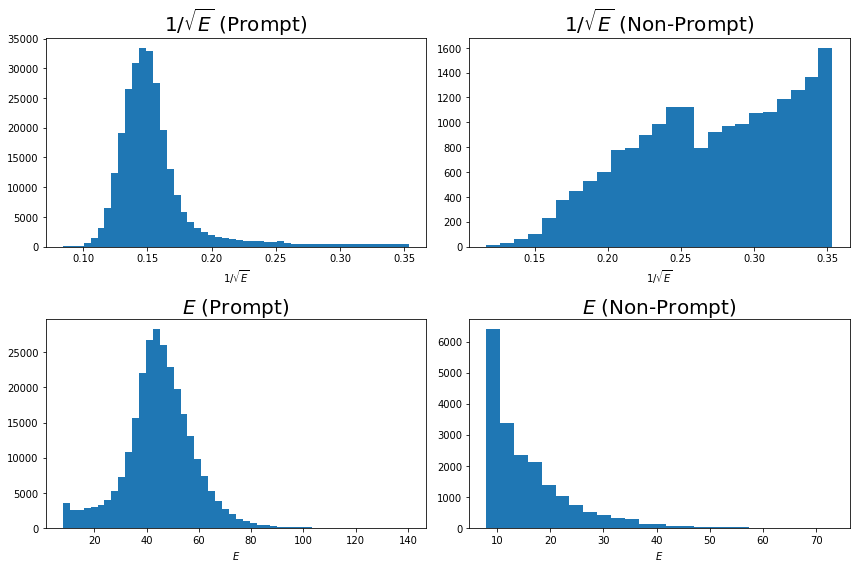

In [4]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
plt.title(r"$1/\sqrt{E}$ (Prompt)",fontsize=20)
plt.xlabel("$1/\sqrt{E}$")
prompt_invE_hist = plt.hist(prompt[:,25],50)
ax = fig.add_subplot(2,2,2)
plt.title(r"$1/\sqrt{E}$ (Non-Prompt)",fontsize=20)
plt.xlabel("$1/\sqrt{E}$")
nonprompt_invE_hist = plt.hist(non_prompt[:,25],25)
ax = fig.add_subplot(2,2,3)
plt.hist(prompt[:,25]**-2,50)
plt.title(r"$E$ (Prompt)",fontsize=20)
plt.xlabel("$E$")
ax = fig.add_subplot(2,2,4)
plt.hist(non_prompt[:,25]**-2,25)
plt.title(r"$E$ (Non-Prompt)",fontsize=20)
plt.xlabel("$E$")
plt.tight_layout()

**5-parameter spline fit** [hidden]

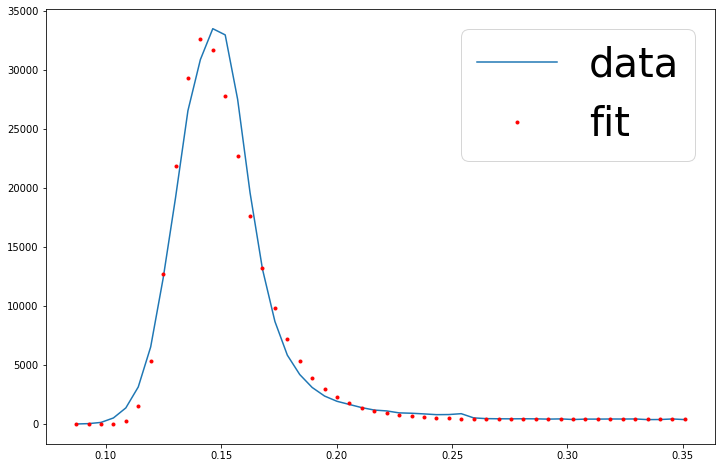

In [5]:
def prompt_spline(x,a,b,c,d,e):
    if (np.size(param) != 5):
        print("param must have size = 5")
    
    return np.exp(a + b * np.log(x) +
        c * np.log(x)**2 +
        d * np.log(x)**3 +
        e * np.log(x)**4)

#param = (49106.129, -66807.181, 32507.609, -6690.8605, 494.94367)
param = np.ones(5)

binedges = prompt_invE_hist[1]
xdata = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
ydata=prompt_invE_hist[0]
sigma = np.sqrt(prompt_invE_hist[0])
sigma[sigma==0]=1.

popt, pcov = curve_fit(prompt_spline, xdata, ydata,sigma=sigma,absolute_sigma=True)

fig = plt.figure(figsize=(12,8))
plt.plot(xdata,ydata,label="data")
plt.plot(xdata, prompt_spline(xdata, *popt), 'r.', label='fit')
plt.legend(fontsize=40)

[-1.78673471e+02  1.60706186e+04 -2.80966344e+04  5.90435434e-01
  1.55619238e+03]


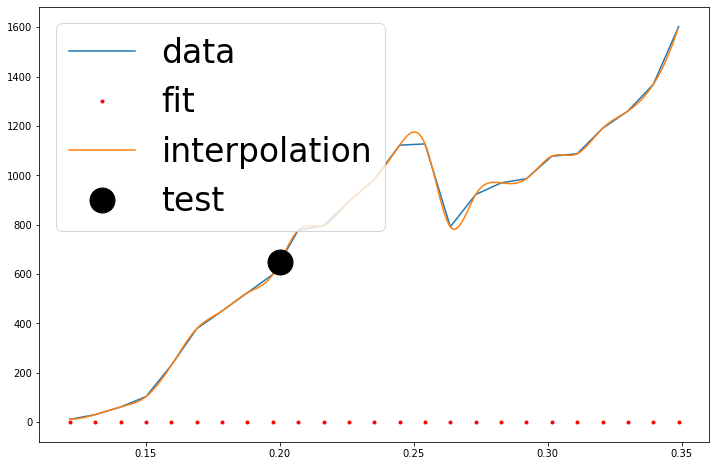

In [6]:
def nonprompt_spline(inv_sqrt_x,a,b,c,d,e):
    x = inv_sqrt_x
    r = 0.5 * (1 + scipy.special.erf(1e+4 * (d - x))) * \
        (a * x**4 + b * x**3 + c * x**2 -
         (4 * a * (d)**3 +
          3 * b * (d)**2 +
          2 * c * (d)) * x +
         (e) + 3 * a * (d)**4 +
         2 * b * (d)**3 + c * (d)**2) + \
        0.5 * (1 + scipy.special.erf(1e+4 * (x - d))) * e
    #r *= reweight_prompt(inv_sqrt_x)
    return r

#param = (49106.129, -66807.181, 32507.609, -6690.8605, 494.94367)
#param = np.ones(5)
param = (-16925.763, 22179.933, -10359.786, 2078.5736, -152.59025)
param = [-1.78673471e+02,  1.60706186e+04, -2.80966344e+04,  5.90435434e-01,
  1.55619238e+03]

binedges = nonprompt_invE_hist[1]
xdata = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
ydata=nonprompt_invE_hist[0]

from scipy.interpolate import interp1d
xnew = np.linspace(0.122, 0.3485, num=1000, endpoint=True)
tck = scipy.interpolate.splrep(xdata, ydata, s=0)
ynew = scipy.interpolate.splev(xnew, tck, der=0)
test = scipy.interpolate.splev(0.2,tck,der=0)

popt, pcov = curve_fit(nonprompt_spline, xdata, ydata, p0=[-16925.763, 22179.933, -10359.786, 2078.5736, -152.59025])
print(popt)

fig = plt.figure(figsize=(12,8))
plt.plot(xdata,ydata,label="data")
plt.plot(xdata, prompt_spline(xdata, *popt), 'r.', label='fit')
plt.plot(xnew,ynew,label="interpolation")
plt.plot(0.2,test,'k.',label="test",markersize=50)
plt.legend(fontsize=33,loc="upper left")

In [15]:
def hist_and_spline(data,ax=None):
    if ax is None:
        ax = plt.gca()
    y,binEdges = np.histogram(data,50)
    y_error = np.sqrt(y)
    y_error[y_error==0] = 1.
    w = 1/y_error
    x = 0.5*(binEdges[1:]+binEdges[:-1]) #bin centers
    width = x[1]-x[0]
    plt.bar(x, y, width=width, yerr=y_error,label="data")

    tck = scipy.interpolate.splrep(x, y, w, s=0)
    xnew = np.linspace(x[0], x[-1], num=1000, endpoint=True)
    ynew = scipy.interpolate.splev(xnew, tck, der=0)
    plt.plot(xnew,ynew,"r--",label="Spline",alpha=0.5,markersize = 4,linewidth=4)
    plt.legend(fontsize=20)
    return ax  

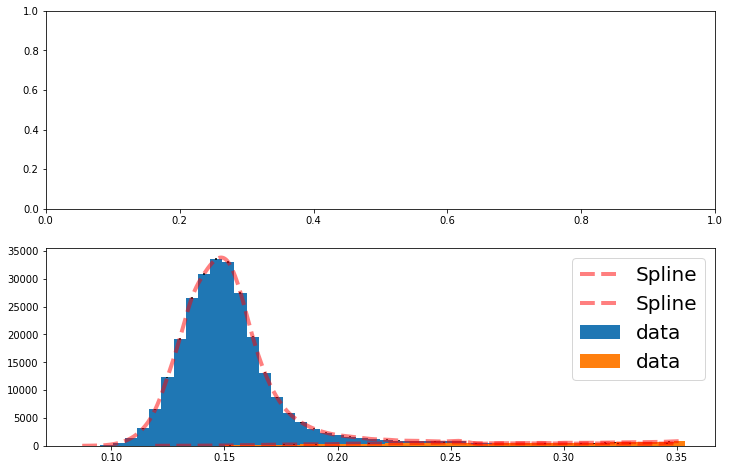

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0] = prompt_fig = hist_and_spline(prompt[:,25],axes[0])
axes[1] = nonprompt_fig = hist_and_spline(non_prompt[:,25],axes[1])

<Figure size 864x576 with 0 Axes>

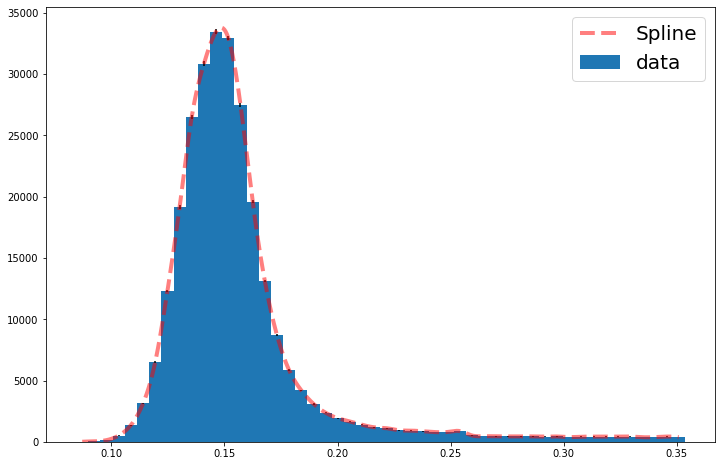

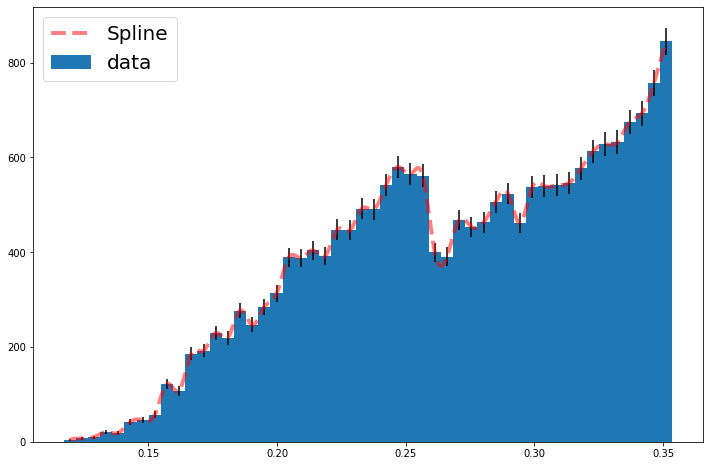

In [8]:
fig = plt.figure(figsize=(12,8))
prompt_fig = hist_and_spline(prompt[:,25])
nonprompt_fig = hist_and_spline(non_prompt[:,25])

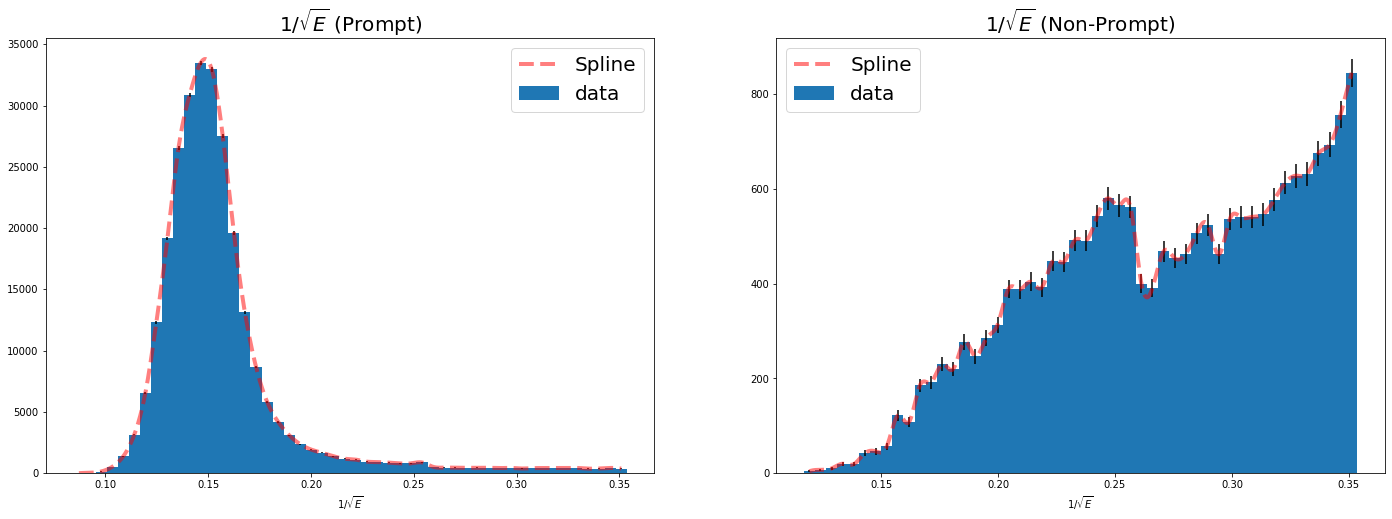

In [23]:
fig = plt.figure(figsize=(24,8))

#prompt
ax = fig.add_subplot(1,2,1)
y,binEdges = np.histogram(prompt[:,25],50)
y_error = np.sqrt(y)
y_error[y_error==0] = 1.
w = 1/y_error
x = 0.5*(binEdges[1:]+binEdges[:-1]) #bin centers
width = x[1]-x[0]
plt.bar(x, y, width=width, yerr=y_error,label="data")

tck = scipy.interpolate.splrep(x, y, w, s=0)
xnew = np.linspace(x[0], x[-1], num=1000, endpoint=True)
ynew = scipy.interpolate.splev(xnew, tck, der=0)
plt.plot(xnew,ynew,"r--",label="Spline",alpha=0.5,markersize = 4,linewidth=4)
plt.title(r"$1/\sqrt{E}$ (Prompt)",fontsize=20)
plt.xlabel("$1/\sqrt{E}$")
plt.legend(fontsize=20)

#non-prompt
ax = fig.add_subplot(1,2,2)
y,binEdges = np.histogram(non_prompt[:,25],50)
y_error = np.sqrt(y)
y_error[y_error==0] = 1.
w = 1/y_error
x = 0.5*(binEdges[1:]+binEdges[:-1]) #bin centers
width = x[1]-x[0]
plt.bar(x, y, width=width, yerr=y_error,label="data")

tck = scipy.interpolate.splrep(x, y, w, s=0)
xnew = np.linspace(x[0], x[-1], num=1000, endpoint=True)
ynew = scipy.interpolate.splev(xnew, tck, der=0)
plt.plot(xnew,ynew,"r--",label="Spline",alpha=0.5,markersize = 4,linewidth=4)
plt.title(r"$1/\sqrt{E}$ (Non-Prompt)",fontsize=20)
plt.xlabel("$1/\sqrt{E}$")
plt.legend(fontsize=20)

In [24]:
def get_spline(data):
    y,bin_edges = np.histogram(data,50)
    y_error = np.sqrt(y)
    y_error[y_error == 0] = 1
    w = 1/y_error
    x = 0.5*(binEdges[1:]+binEdges[:-1])
    return scipy.interpolate.splrep(x, y, w, s=0);

def reweight_prompt(cluster_Inv_E,norm):
    x = cluster_Inv_E**(-2)
    tck = get_spline(x)
    fit = scipy.interpolate.splev(x, tck, der=0)
 
    return norm / fit

def reweight_nonprompt(cluster_Inv_E,norm):
    x = cluster_Inv_E**(-2)
    tck = get_spline(x)
    r = scipy.interpolate.splev(x, tck, der=0)
    r *= reweight_prompt(cluster_Inv_E,norm)
    return r

In [29]:
y = prompt_bools
norm = len(y[ y[:] == 1 ]) / len(y[ y[:] == 0 ]) #N_Prompt/N_non-prompt
test = reweight_nonprompt(non_prompt[:,25],norm)
print(test)
test = reweight_prompt(prompt[:,25],norm)
print(test)

[14.0431837 14.0431837 14.0431837 ... 14.0431837 14.0431837 14.0431837]
[1.30776340e-11 1.74640283e-11 1.51522791e-11 ... 7.58024267e-12
 1.74267467e-11 9.25047333e-12]


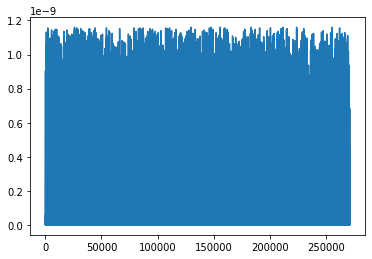

In [31]:
plt.plot(prompt[:,25]*test)

In [34]:
import photon_dnn.py

AttributeError: module 'tensorflow' has no attribute 'set_random_seed'